In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import lsst.syseng.throughputs as st
from lsst.sims.photUtils import PhotometricParameters, Sed
import galsim
import matplotlib.pyplot as plt

from lsst.cwfs.instrument import Instrument

### We use Eq (6) in LSE-40. With the baseline system as defined by syseng_throughput (including hardware & atmosphere), We can easily map a source magnitude to a source count. This is not affected by seeing. 
For point sources, seeing comes into play because it determines how far to spread the total source count. For donuts, however, seeing only blurs the edge. When we are thinking about what fraction of light from the point source gets into the brightest pixels, we are largely not affected by seeing.

In [2]:
# full_well for a 30s visit, in e-
full_well = 150e3  #typical for e2v sensors. ITL is typically 200k. We try to be conservative and use the smaller.
full_well2 = 100e3  #some sensors can be as low as 100K e-.

snrLim = 10

## We first determine what fraction of the flux will be in the brightest pixel
### We could look at a simulated donut (with no background).
Note that this ratio will still depend on specific aberrations. We also need to be careful if we are looking at a vignetted donut, in which case the denominator should be all the light emitted by the source, including the vignetted light.
### As the first approximatioon, here we simply assume field center, and uniform intensity. 

In [3]:
inst=Instrument('lsst15',200)
r = inst.donutR/inst.pixelSize
Area = np.pi* (r**2 - (r*inst.obscuration)**2)
ratio = 1./Area
print(ratio)

0.0001371230205311955


### Baseline LSST system, as defined in syseng_throughput

In [4]:
defaultDirs = st.setDefaultDirs()
hardware, system = st.buildHardwareAndSystem(defaultDirs)

### Default photometric parameters, as used in standard m5 calculations (except we run cwfs on one exposure only, nexp = 1)

In [5]:
exptime=15 
nexp=1
readnoise=8.8 
othernoise=0 
darkcurrent=0.2
effarea=np.pi*(6.423/2*100)**2
X=1.0

# PhotometricParameters object for standard m5 calculations.
photParams_std = PhotometricParameters(exptime=exptime, nexp=nexp,
                                           gain=1.0, effarea=effarea, readnoise=readnoise,
                                           othernoise=othernoise, darkcurrent=darkcurrent)

### Let's make sure we can reproduce standard m5 results

In [6]:
m5 = st.makeM5(hardware, system, darksky=None, 
                      exptime=exptime, nexp=nexp, readnoise=readnoise, othernoise=othernoise, darkcurrent=darkcurrent,
                      effarea=effarea, X=1.0)

In [7]:
m5

,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,0.92,0.80824,22.960730,40.420286,27.009181,0.035837,0.057997,0.522669,0.037458,23.155158,0.568632,0.353902,23.462511,393.332204,23.9,23.4
g,0.87,0.76714,22.257758,205.547397,28.399288,0.128938,0.154358,0.195371,0.038234,24.440312,0.174894,0.090048,24.456850,566.325959,25.0,24.6
r,0.83,0.73426,21.196590,409.398572,28.177407,0.105106,0.115690,0.104170,0.038579,24.461761,0.095541,0.045673,23.998819,703.925715,24.7,24.3
i,0.80,0.70960,20.477419,586.743900,27.879556,0.079889,0.085493,0.073607,0.038735,24.357933,0.068588,0.031395,23.575376,790.247862,24.0,23.6
z,0.78,0.69316,19.599578,891.496191,27.481805,0.055384,0.057871,0.047694,0.038922,24.197484,0.046243,0.020046,23.003495,927.716733,23.3,22.9
y,0.76,0.67672,18.610405,1185.511680,26.687500,0.026648,0.030944,0.162291,0.039029,23.755786,0.035194,0.014573,22.095412,1030.211963,22.1,21.7


### Set up the dataframe

In [8]:
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
properties = ['SatLim', 'SNR%dLim'%snrLim, 'SNR%dS'%snrLim, 'SNR%dB'%snrLim]
d = pd.DataFrame(index=filterlist, columns=properties, dtype='float')

### Calculate the saturation limits

In [9]:
for f in system:
    flatsource = Sed()
    flatsource.setFlatSED(wavelen_min=system[f].wavelen_min, wavelen_max=system[f].wavelen_max,
                              wavelen_step=system[f].wavelen_step)
    adu = flatsource.calcADU(system[f], photParams=photParams_std) #this takes into account the effective area
    
    adu0 = adu*ratio
    key = 'SatLim'
    #because setFlatSED() assumes a m=0 star
    # we use gain=1.0, so adu = number of e-
    # we also get rid of skycounts from each pixel. This has miminal effect on results; we ignore readnoise here
    NN = full_well-m5.skyCounts[f] #max number of e- we can accommodate in 1 pixel
    d[key].loc[f] = np.log10(adu0/(NN))/2*5
    # The above can also be obtained this way, 
    # (but flatsource has to be re-initialized for each calculation)
    # Scale fnu so that adu0 is equal to full well.
    #flatsource.fnu = flatsource.fnu * (full_well/adu0)
    #d[key].loc[f] = flatsource.calcMag(system[f])

### Faint limit that gives SNR = snrLim
#### We use standard dark sky (Peter's model) to estimate B.

\begin{equation}
SNR = \frac{S}{\sqrt{S+B}}
\end{equation}

In [10]:
for f in filterlist:
    flatsource = Sed()
    flatsource.setFlatSED(wavelen_min=system[f].wavelen_min, wavelen_max=system[f].wavelen_max,
                              wavelen_step=system[f].wavelen_step)
    adu = flatsource.calcADU(system[f], photParams=photParams_std)
    
    adu0 = adu*ratio
    key = 'SNR%dLim'%snrLim
    #because setFlatSED() assumes a m=0 star
    # we use gain=1.0, so adu = number of e-
    myB = m5.skyCounts[f] + np.sqrt(photParams_std.readnoise**2*photParams_std.nexp)
    NN = (snrLim**2+np.sqrt(snrLim**4+4*snrLim**2*myB))/2 #min number of e- we need in 1 pixel
    print('confirming SNR in %s = %.0f, sky count = %.0f, requiring number of e-: %.0f'%(
        f, NN/np.sqrt(NN+myB), m5.skyCounts[f], NN))
    d[key].loc[f] = np.log10(adu0/(NN))/2*5
    # The above can also be obtained this way, 
    # (but flatsource has to be re-initialized for each calculation)
    # Scale fnu so that adu0 is equal to full well.
    #flatsource.fnu = flatsource.fnu * (full_well/adu0)
    #d[key].loc[f] = flatsource.calcMag(system[f])
    key = 'SNR%dS'%snrLim
    d[key].loc[f] = NN
    key = 'SNR%dB'%snrLim
    d[key].loc[f] = m5.skyCounts[f] 

confirming SNR in u = 10, sky count = 40, requiring number of e-: 136
confirming SNR in g = 10, sky count = 206, requiring number of e-: 205
confirming SNR in r = 10, sky count = 409, requiring number of e-: 261
confirming SNR in i = 10, sky count = 587, requiring number of e-: 299
confirming SNR in z = 10, sky count = 891, requiring number of e-: 354
confirming SNR in y = 10, sky count = 1186, requiring number of e-: 399


In [11]:
d.join(m5)

,SatLim,SNR10Lim,SNR10S,SNR10B,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,7.352250,14.957132,136.151196,40.420286,0.92,0.80824,22.960730,40.420286,27.009181,0.035837,0.057997,0.522669,0.037458,23.155158,0.568632,0.353902,23.462511,393.332204,23.9,23.4
g,8.743553,15.904452,204.708564,205.547397,0.87,0.76714,22.257758,205.547397,28.399288,0.128938,0.154358,0.195371,0.038234,24.440312,0.174894,0.090048,24.456850,566.325959,25.0,24.6
r,8.523151,15.420797,260.522819,409.398572,0.83,0.73426,21.196590,409.398572,28.177407,0.105106,0.115690,0.104170,0.038579,24.461761,0.095541,0.045673,23.998819,703.925715,24.7,24.3
i,8.226587,14.972993,299.107186,586.743900,0.80,0.70960,20.477419,586.743900,27.879556,0.079889,0.085493,0.073607,0.038735,24.357933,0.068588,0.031395,23.575376,790.247862,24.0,23.6
z,7.831053,14.391728,354.186816,891.496191,0.78,0.69316,19.599578,891.496191,27.481805,0.055384,0.057871,0.047694,0.038922,24.197484,0.046243,0.020046,23.003495,927.716733,23.3,22.9
y,7.038891,13.467565,399.186437,1185.511680,0.76,0.67672,18.610405,1185.511680,26.687500,0.026648,0.030944,0.162291,0.039029,23.755786,0.035194,0.014573,22.095412,1030.211963,22.1,21.7


### It may be easier to reference the results if we use the zeropoints (the AB mag of the source that produces 1 e- per second on the detector)

In [12]:
d_zp = pd.DataFrame(index=filterlist, columns=properties, dtype='float')
for f in system:
    key = 'SatLim'
    NN = full_well-m5.skyCounts[f] #max number of e- we can accommodate in 1 pixel; we ignore readnoise here
    #number of electrons we can accomodate for the source in 30 sec
    ne = (NN)/ratio
    #number of electrons we can accomodate for this source in 1 sec
    ne = ne/(exptime*nexp)
    d_zp[key].loc[f] = (m5.Zp_t[f]-2.5*np.log10(ne))
    
    key = 'SNR%dLim'%snrLim
    myB = m5.skyCounts[f] + np.sqrt(photParams_std.readnoise**2*photParams_std.nexp)
    NN = (snrLim**2+np.sqrt(snrLim**4+4*snrLim**2*myB))/2 #min number of e- we need in 1 pixel
    #number of electrons we can accomodate for the source in 30 sec
    ne = (NN)/ratio
    #number of electrons we can accomodate for this source in 1 sec
    ne = ne/(exptime*nexp)
    d_zp[key].loc[f] = (m5.Zp_t[f]-2.5*np.log10(ne))
    
    key = 'SNR%dS'%snrLim
    d_zp[key].loc[f] = NN
    key = 'SNR%dB'%snrLim
    d_zp[key].loc[f] = m5.skyCounts[f] 

In [13]:
round(d_zp - d)  #should be idential to above calculations

,SatLim,SNR10Lim,SNR10S,SNR10B
u,0.0,0.0,0.0,0.0
g,0.0,-0.0,0.0,0.0
r,0.0,0.0,0.0,0.0
i,0.0,0.0,0.0,0.0
z,0.0,-0.0,0.0,0.0
y,0.0,0.0,0.0,0.0


### Now make the plots

In [14]:
colors = ['blue', 'green', 'red', '0.75', '0.50', '0.25']
d_plot = pd.DataFrame(index=filterlist, columns=['SatLimFromPlot', 'SNR%dLimFromPlot'%snrLim], dtype='float')
d_2016 = pd.DataFrame(index=filterlist, columns=['SatLim','SNR%dLim'%snrLim], dtype='float')

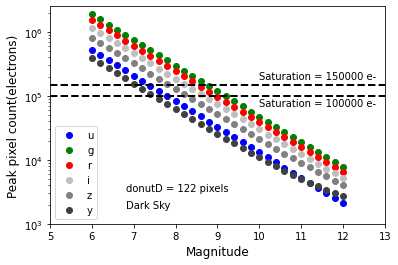

In [15]:
fig, ax = plt.subplots()
for i,f in enumerate(filterlist):
    mags = []
    npeaks = []
    flatsource = Sed()
    flatsource.setFlatSED(wavelen_min=system[f].wavelen_min, wavelen_max=system[f].wavelen_max,
                              wavelen_step=system[f].wavelen_step)
    adu = flatsource.calcADU(system[f], photParams=photParams_std)
    adu0 = adu*ratio #a m=0 start produces this adu0 in the center pixel
    for m in range(31):
        mag = 6.0 + 0.2 * m
        mags.append(mag)
        npeak = adu0*10**(-mag/2.5)+m5.skyCounts[f] #; we ignore readnoise here
        npeaks.append(npeak)
    plt.scatter(mags, npeaks, label=f, color=colors[i])
    #print(npeak)
    #break
    d_plot.SatLimFromPlot.loc[f] = mags[np.argmax(np.array(npeaks)<full_well)]
plt.plot([5.0,20.0],[full_well, full_well], ls = '--', lw = 2, color='black')
plt.text(10, full_well*1.20, "Saturation = %d e-"%full_well, color = 'black')
plt.plot([5.0,20.0],[full_well2, full_well2], ls = '--', lw = 2, color='black')
plt.text(10, full_well2*0.7, "Saturation = %d e-"%full_well2, color = 'black')
plt.text(0.3, 0.24, "donutD = %.0f pixels"%(r*2), color = 'black', transform=fig.transFigure)
plt.text(0.3, 0.18, "Dark Sky", color = 'black', transform=fig.transFigure)
plt.legend()
plt.yscale('log')
plt.xlim(5.0,13)
plt.ylim(1e3, 2.5e6)
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('Peak pixel count(electrons)', fontsize=12);

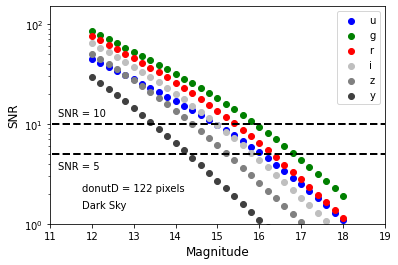

In [16]:
snrLim2 = 5
fig, ax = plt.subplots()
for i,f in enumerate(filterlist):
    mags = []
    snrs = []
    flatsource = Sed()
    flatsource.setFlatSED(wavelen_min=system[f].wavelen_min, wavelen_max=system[f].wavelen_max,
                              wavelen_step=system[f].wavelen_step)
    adu = flatsource.calcADU(system[f], photParams=photParams_std)
    adu0 = adu*ratio #a m=0 start produces this adu0 in the center pixel
    for m in range(31):
        mag = 12.0 + 0.2 * m
        mags.append(mag)
        s = adu0*10**(-mag/2.5)
        myB = m5.skyCounts[f] + np.sqrt(photParams_std.readnoise**2*photParams_std.nexp)
        snr = s/np.sqrt(s+myB)
        snrs.append(snr)
    plt.scatter(mags, snrs, label=f, color=colors[i])
    #print(npeak)
    #break
    key = 'SNR%dLimFromPlot'%snrLim
    d_plot[key].loc[f] = mags[np.argmax(np.array(snrs)<snrLim)]
plt.plot([1.0,20.0],[snrLim, snrLim], ls = '--', lw = 2, color='black')
plt.text(11.2, snrLim*1.20, "SNR = %d"%snrLim, color = 'black')
plt.plot([1.0,20.0],[snrLim2, snrLim2], ls = '--', lw = 2, color='black')
plt.text(11.2, snrLim2*0.7, "SNR = %d"%snrLim2, color = 'black')
plt.text(0.2, 0.24, "donutD = %.0f pixels"%(r*2), color = 'black', transform=fig.transFigure)
plt.text(0.2, 0.18, "Dark Sky", color = 'black', transform=fig.transFigure)
plt.legend()
plt.yscale('log')
plt.xlim(11.0,19.0)
plt.ylim(1, 1.5e2)
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('SNR', fontsize=12);

In [17]:
#check consistency with above calculations.
d_plot.join(d)

,SatLimFromPlot,SNR10LimFromPlot,SatLim,SNR10Lim,SNR10S,SNR10B
u,7.4,15.0,7.352250,14.957132,136.151196,40.420286
g,8.8,16.0,8.743553,15.904452,204.708564,205.547397
r,8.6,15.6,8.523151,15.420797,260.522819,409.398572
i,8.4,15.0,8.226587,14.972993,299.107186,586.743900
z,8.0,14.4,7.831053,14.391728,354.186816,891.496191
y,7.2,13.6,7.038891,13.467565,399.186437,1185.511680


In [18]:
#values copied from https://github.com/lsst-ts/ts_wep/blob/master/python/lsst/ts/wep/bsc/Filter.py  commit b5dcb9a
d_2016.SatLim['u'] = 7.94
d_2016['SNR%dLim'%snrLim]['u'] = 14.80

d_2016.SatLim['g'] = 9.74
d_2016['SNR%dLim'%snrLim]['g'] = 16.17

d_2016.SatLim['r'] = 9.56
d_2016['SNR%dLim'%snrLim]['r'] = 15.73

d_2016.SatLim['i'] = 9.22
d_2016['SNR%dLim'%snrLim]['i'] = 15.26

d_2016.SatLim['z'] = 8.83
d_2016['SNR%dLim'%snrLim]['z'] = 14.68

d_2016.SatLim['y'] = 8.02
d_2016['SNR%dLim'%snrLim]['y'] = 13.76

In [19]:
#negative means we are brighter now
d-d_2016

,SNR10B,SNR10Lim,SNR10S,SatLim
u,NaN,0.157132,NaN,-0.587750
g,NaN,-0.265548,NaN,-0.996447
r,NaN,-0.309203,NaN,-1.036849
i,NaN,-0.287007,NaN,-0.993413
z,NaN,-0.288272,NaN,-0.998947
y,NaN,-0.292435,NaN,-0.981109


#### Now do the same thing for bright sky. We will only do the calculations using zero points below.

In [20]:
#to make sure we add the 0.4 mag to the sky correctly, let's verify we can use darksky mag to reproduce dark sky count
# can we use the zero point to do that?
for f in filterlist:
    print(f, m5.Zp_t[f], m5.skyMag[f], 10**((m5.Zp_t[f] - m5.skyMag[f])/2.5)*30*0.2*0.2, m5.skyCounts[f])
#The answer is no. The reason is because the zero point contains effect of atmosphere+hardware. 
#The photons produced by a certain sky mag only go through the hardware, not atmosphere

u 27.009181343298994 22.960730180229127 49.953015613436925 40.420286418944166
g 28.39928844119809 22.257757986434328 343.3945735171815 205.54739700718122
r 28.17740748284969 21.19658987481676 743.8892611843139 409.3985724593956
i 27.879555761190304 20.477418932398777 1096.5690336979158 586.7438995182729
z 27.48180492203217 19.599578356350023 1706.3647555821005 891.4961913181043
y 26.68750015086725 18.61040493721628 2041.8288294344675 1185.5116804539082


In [21]:
import os
from lsst.utils import getPackageDir
def skyMag2Count(skyMag, f, hardware, photParams):
    '''
    inputs:
        skyMag is the sky magnitude
        f is the filter band
        hardware: an bandpass object as defined in the syseng_throughput package
        photParams: an PhotometricParameters object as defined in the syseng_throughput package
    output:
        skycount in each pixel
    '''
    darksky = Sed()
    darksky.readSED_flambda(os.path.join(getPackageDir('syseng_throughputs'),
                                             'siteProperties', 'darksky.dat'))
    fNorm = darksky.calcFluxNorm(skyMag, hardware)
    darksky.multiplyFluxNorm(fNorm)
    skyCount = (darksky.calcADU(hardware, photParams=photParams)* photParams.platescale**2)
    return fNorm, skyCount

In [22]:
# Now we can reproduce m5 sky count with m5 sky mag, we are confident to proceed
for f in filterlist:
    fNorm, skyCount = skyMag2Count(m5.skyMag[f], f, hardware[f], photParams_std)
    print(f, fNorm, skyCount, m5.skyCounts[f])

u 1.0 40.420286418944166 40.420286418944166
g 1.0 205.54739700718122 205.54739700718122
r 1.0 409.3985724593956 409.3985724593956
i 1.0 586.7438995182729 586.7438995182729
z 1.0 891.4961913181043 891.4961913181043
y 1.0 1185.5116804539082 1185.5116804539082


skyBrightMag below is sky brightness at 50 deg from full moon (based on DeCam experience)

The 11 yr solar cycle gives 0.5 mag change in v band.  For SpaceX studies, Tony recommended adding 0.4 mag to the sky due to solar cycle.
We will do the same here.

In [23]:
skyBrightMag = {'u': 17.7, 'g':19.4, 'r':19.7, 'i':19.4, 'z':18.2, 'y':17.7}

In [24]:
skyCounts = {}
for f in filterlist:
    skyCount = 10**((0.4+m5.skyMag[f]-skyBrightMag[f])/2.5)*m5.skyCounts[f] # we can actually simply calculate sky count this way.
    skyCounts[f]=skyCount
    fNorm, skyCount1 = skyMag2Count(skyBrightMag[f]-0.4, f, hardware[f], photParams_std)
    print('%s, %.2f, %.2f, %.2f'%(f, skyCount, skyCount1, skyCount-skyCount1)) # this is just to double check

u, 7428.33, 7428.33, -0.00
g, 4130.62, 4130.62, 0.00
r, 2348.46, 2348.46, -0.00
i, 2287.79, 2287.79, -0.00
z, 4676.82, 4676.82, -0.00
y, 3963.40, 3963.40, 0.00


In [25]:
skyCounts

{'u': 7428.33461613624,
 'g': 4130.619357350411,
 'r': 2348.4551679281544,
 'i': 2287.789991934199,
 'z': 4676.821932008422,
 'y': 3963.39915253661}

In [26]:
#use zero points to calculate saturation magnitudes under bright sky
d_zp_bright = pd.DataFrame(index=filterlist, columns=properties, dtype='float')
for f in system:
    key = 'SatLim'
    NN = full_well-skyCounts[f] #; we ignore readnoise here
    #number of electrons we can accomodate for the source in 30 sec
    ne = (NN)/ratio
    #number of electrons we can accomodate for this source in 1 sec
    ne = ne/(exptime*nexp)
    d_zp_bright[key].loc[f] = (m5.Zp_t[f]-2.5*np.log10(ne))
    
    key = 'SNR%dLim'%snrLim
    myB = skyCounts[f] + np.sqrt(photParams_std.readnoise**2*photParams_std.nexp)
    NN = (snrLim**2+np.sqrt(snrLim**4+4*snrLim**2*myB))/2 #min number of e- we need in 1 pixel
    #number of electrons we can accomodate for the source in 30 sec
    ne = (NN)/ratio
    #number of electrons we can accomodate for this source in 1 sec
    ne = ne/(exptime*nexp)
    d_zp_bright[key].loc[f] = (m5.Zp_t[f]-2.5*np.log10(ne))
    
    key = 'SNR%dS'%snrLim
    d_zp_bright[key].loc[f] = NN
    key = 'SNR%dB'%snrLim
    d_zp_bright[key].loc[f] = skyCounts[f] 

In [27]:
d_zp_bright

,SatLim,SNR10Lim,SNR10S,SNR10B
u,7.407102,12.890014,913.836479,7428.334616
g,8.772382,14.576826,695.323125,4130.619357
r,8.537317,14.633287,538.083514,2348.455168
i,8.239019,14.348130,531.828807,2287.789992
z,7.858972,13.597113,736.339707,4676.821932
y,7.059350,12.885671,682.234067,3963.399153


In [28]:
#negative means we are brighter now
d_zp_bright - d_zp

,SatLim,SNR10Lim,SNR10S,SNR10B
u,0.054852,-2.067118,777.685282,7387.914330
g,0.028829,-1.327627,490.614561,3925.071960
r,0.014166,-0.787510,277.560695,1939.056595
i,0.012432,-0.624863,232.721621,1701.046092
z,0.027919,-0.794615,382.152891,3785.325741
y,0.020459,-0.581894,283.047629,2777.887472


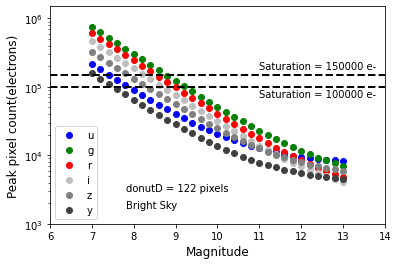

In [29]:
d_plot_zp_bright = pd.DataFrame(index=filterlist, columns=['SatLimFromPlot', 'SNR%dLimFromPlot'%snrLim], dtype='float') # b for bright sky
fig, ax = plt.subplots()
for i,f in enumerate(filterlist):
    mags = []
    npeaks = []
    flatsource = Sed()
    flatsource.setFlatSED(wavelen_min=system[f].wavelen_min, wavelen_max=system[f].wavelen_max,
                              wavelen_step=system[f].wavelen_step)
    adu = flatsource.calcADU(system[f], photParams=photParams_std)
    adu0 = adu*ratio #a m=0 start produces this adu0 in the center pixel
    for m in range(31):
        mag = 7.0 + 0.2 * m
        mags.append(mag)
        npeak = adu0*10**(-mag/2.5)+skyCounts[f] #; we ignore readnoise here
        npeaks.append(npeak)
    plt.scatter(mags, npeaks, label=f, color=colors[i])
    #print(npeak)
    #break
    d_plot_zp_bright.SatLimFromPlot.loc[f] = mags[np.argmax(np.array(npeaks)<full_well)]
plt.plot([6.0,20.0],[full_well, full_well], ls = '--', lw = 2, color='black')
plt.text(11, full_well*1.20, "Saturation = %d e-"%full_well, color = 'black')
plt.plot([6.0,20.0],[full_well2, full_well2], ls = '--', lw = 2, color='black')
plt.text(11, full_well2*0.7, "Saturation = %d e-"%full_well2, color = 'black')
plt.text(0.3, 0.24, "donutD = %.0f pixels"%(r*2), color = 'black', transform=fig.transFigure)
plt.text(0.3, 0.18, "Bright Sky", color = 'black', transform=fig.transFigure)
plt.legend()
plt.yscale('log')
plt.xlim(6.0,14.0)
plt.ylim(1e3, 1.5e6)
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('Peak pixel count(electrons)', fontsize=12);
#plt.savefig('Peak_count_by_band_brightSky_donut.pdf')

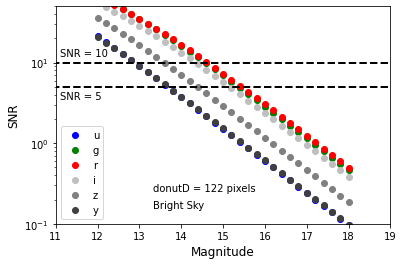

In [30]:
fig, ax = plt.subplots()
for i,f in enumerate(filterlist):
    mags = []
    snrs = []
    flatsource = Sed()
    flatsource.setFlatSED(wavelen_min=system[f].wavelen_min, wavelen_max=system[f].wavelen_max,
                              wavelen_step=system[f].wavelen_step)
    adu = flatsource.calcADU(system[f], photParams=photParams_std)
    adu0 = adu*ratio #a m=0 start produces this adu0 in the center pixel
    for m in range(31):
        mag = 12.0 + 0.2 * m
        mags.append(mag)
        s = adu0*10**(-mag/2.5)
        myB = skyCounts[f] + np.sqrt(photParams_std.readnoise**2*photParams_std.nexp)
        snr = s/np.sqrt(s+myB)
        snrs.append(snr)
    plt.scatter(mags, snrs, label=f, color=colors[i])#, s=10)
    #print(f, snrs)
    #break
    d_plot_zp_bright['SNR%dLimFromPlot'%snrLim].loc[f] = mags[np.argmax(np.array(snrs)<snrLim)]
plt.plot([1.0,20.0],[snrLim, snrLim], ls = '--', lw = 2, color='black')
plt.text(11.1, snrLim*1.20, "SNR = %d"%snrLim, color = 'black')
plt.plot([1.0,20.0],[snrLim2, snrLim2], ls = '--', lw = 2, color='black')
plt.text(11.1, snrLim2*0.7, "SNR = %d"%snrLim2, color = 'black')
plt.text(0.35, 0.24, "donutD = %.0f pixels"%(r*2), color = 'black', transform=fig.transFigure)
plt.text(0.35, 0.18, "Bright Sky", color = 'black', transform=fig.transFigure)
plt.legend()
plt.yscale('log')
plt.xlim(11.0,19.0)
plt.ylim(.1, 0.5e2)
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('SNR', fontsize=12);

In [31]:
d_plot_zp_bright - d_plot

,SatLimFromPlot,SNR10LimFromPlot
u,0.2,-2.0
g,0.0,-1.4
r,0.0,-0.8
i,0.0,-0.6
z,0.0,-0.8
y,0.0,-0.6


#### surface brightness at faint limit (SNR ~ 10), in AB mag / arcsec^2

In [32]:
offset = -2.5*np.log10(ratio/photParams_std.platescale**2) #convert to AB mag /pix, then to /arcsec^2
for f in filterlist:
    print('%s, to get SNR of 10, donut surface brightness under dark sky (%.2f) = %.2f, under bright sky (%.2f) =  %.2f'%(
        f, m5.skyMag[f], d['SNR10Lim'][f]+offset, skyBrightMag[f]-0.4, d_zp_bright['SNR10Lim'][f]+offset))

u, to get SNR of 10, donut surface brightness under dark sky (22.96) = 21.12, under bright sky (17.30) =  19.05
g, to get SNR of 10, donut surface brightness under dark sky (22.26) = 22.07, under bright sky (19.00) =  20.74
r, to get SNR of 10, donut surface brightness under dark sky (21.20) = 21.58, under bright sky (19.30) =  20.80
i, to get SNR of 10, donut surface brightness under dark sky (20.48) = 21.14, under bright sky (19.00) =  20.51
z, to get SNR of 10, donut surface brightness under dark sky (19.60) = 20.55, under bright sky (17.80) =  19.76
y, to get SNR of 10, donut surface brightness under dark sky (18.61) = 19.63, under bright sky (17.30) =  19.05


#### signal and background counts at SNR ~ 10, in e-/pixel

In [33]:
for f in filterlist:
    print('%s, to get SNR of 10, donut signal count under dark sky (%.0f) = %.0f, under bright sky (%.0f) =  %.0f'%(
        f, m5.skyCounts[f], d['SNR10S'][f], skyCounts[f], d_zp_bright['SNR10S'][f]))

u, to get SNR of 10, donut signal count under dark sky (40) = 136, under bright sky (7428) =  914
g, to get SNR of 10, donut signal count under dark sky (206) = 205, under bright sky (4131) =  695
r, to get SNR of 10, donut signal count under dark sky (409) = 261, under bright sky (2348) =  538
i, to get SNR of 10, donut signal count under dark sky (587) = 299, under bright sky (2288) =  532
z, to get SNR of 10, donut signal count under dark sky (891) = 354, under bright sky (4677) =  736
y, to get SNR of 10, donut signal count under dark sky (1186) = 399, under bright sky (3963) =  682


#### Star magnitude range 

In [34]:
for f in filterlist:
    print('%s, under dark sky, saturation limit = %.2f, faint limit = %.2f, under bright sky, saturation limit = %.2f, faint limit = %.2f'%(
    f, d['SatLim'][f], d['SNR10Lim'][f], d_zp_bright['SatLim'][f], d_zp_bright['SNR10Lim'][f]))

u, under dark sky, saturation limit = 7.35, faint limit = 14.96, under bright sky, saturation limit = 7.41, faint limit = 12.89
g, under dark sky, saturation limit = 8.74, faint limit = 15.90, under bright sky, saturation limit = 8.77, faint limit = 14.58
r, under dark sky, saturation limit = 8.52, faint limit = 15.42, under bright sky, saturation limit = 8.54, faint limit = 14.63
i, under dark sky, saturation limit = 8.23, faint limit = 14.97, under bright sky, saturation limit = 8.24, faint limit = 14.35
z, under dark sky, saturation limit = 7.83, faint limit = 14.39, under bright sky, saturation limit = 7.86, faint limit = 13.60
y, under dark sky, saturation limit = 7.04, faint limit = 13.47, under bright sky, saturation limit = 7.06, faint limit = 12.89
